# Fixed airfoil in free stream

This notebook demonstrates the use of conformally-mapped bodies and edge conditions to generate flows past an airfoil

In [1]:
using PotentialFlow

In [2]:
using Plots
default(grid = false)

## Set up

The following function computes the right-hand side of the evolution equation. At the beginning of every time-step, we first determine the bound vortex sheet strength required to satisfy the no-flow-through condition, then velocity of all vortex elements. Finally, we need to transform the computed velocities so that they apply to the elements in the circle plane.

In [3]:
function compute_ẋ!(ẋ, x, t)    
    body, freestream, ambient_sys = x
    motion = ẋ[1]
    # update the instantaneous motion of the body with the current motion
    motion.ċ, motion.c̈, motion.α̇, motion.α̈ = motion.kin(t)
        
    Bodies.enforce_no_flow_through!(body, motion, (freestream, ambient_sys), t)
        
    # Zero the velocity
    reset_velocity!(ẋ, x)
        
    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)
    
    # Modify the velocity so that it provides the rate of change in the circle plane.
    Bodies.transform_velocity!(ẋ, ẋ, x, body)
end

compute_ẋ! (generic function with 1 method)

Once we have advected all the vortex elements, we release new blobs from the designated edges of the body. This function adds new blobs to the set with the correct strength to enforce edge conditions.

In [4]:
function shed_new_vorticity!(blobs, edge1, body, freestream, motion, t, spcrit1 = 0.0)    
    # assume that sheet positions are in the circle plane
    
    ϕ = 1/3 # fractional distance from the edge point to the previous blob
    
    # Location edges in physical plane
    zedge1 = body.zs[edge1] # body.c + body.m.z[edge1]*exp(im*body.α)
    
    # positions of previously-released blobs, transformed to physical plane
    zblob1 = conftransform(blobs[end].z,body)

    # positions of new blobs in physical plane
    z1 = ϕ*zblob1 + (1-ϕ)*zedge1

    # positions of new blobs in circle plane
    ζ1 = inverse_conftransform(z1,body)

    # new blobs, with unit strength for now
    blob1 = Vortex.Blob(ζ1, 1.0, δ)
     
    Bodies.enforce_no_flow_through!(body, motion, (freestream, blobs), t) # need blobs in circle plane
    
    # Determine the strengths of the new blobs
    Γ1 = Bodies.vorticity_flux(body, edge1, (body,freestream,blobs), [blob1], t, spcrit1);
    
    # Add the new blobs to the list
    push!(blobs, Vortex.Blob(ζ1, Γ1, blobs[1].δ))
    
end

shed_new_vorticity! (generic function with 2 methods)

## Set up the body, a NACA 4-digit airfoil
The default is a NACA 4412
- The first argument is the camber (0.04 is 4 percent camber)
- The second argument is the location of maximum camber (0.4 means 40 percent of the chord)
- The third argument is the thickness as a fraction of chord.

Try some different choices, like thinner airfoils, uncambered vs cambered.

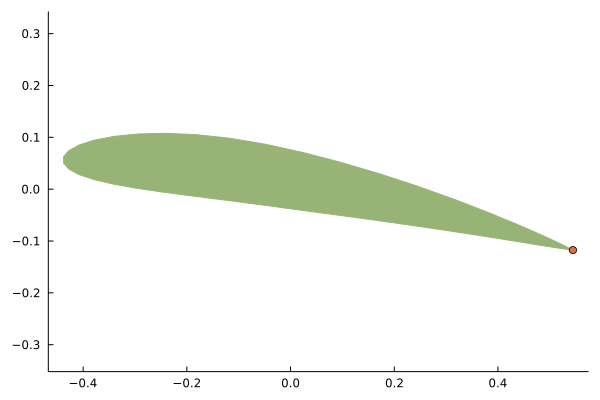

In [5]:
w = SchwarzChristoffel.naca4(0.04,0.4,0.12;len=1)
p = Bodies.Polygon(w);

# Initial centroid position
c = 0.0+0.0im

# Set the angle of attack here. Note that a positive angle of attack is a negative angle here, because the angle 
# represents a counter-clockwise rotation. Try different values.
α₀ = -10π/180

b = Bodies.ConformalBody(p,c,α₀)
plot(b)

# Designate edge from which to release vortices. This find the vertex corresponding to the trailing edge
edgeindices = findall(b.m.angle .== minimum(b.m.angle)) # Look for vertices that have minimum interior angle
kTE = edgeindices[1] # trailing edge for releasing vorticity
# Label the edge in the plot for checking
plot!(real.(b.zs[[kTE]]),imag.(b.zs[[kTE]]),seriestype=:scatter)

### Set up the motion.
In this case, we will set up a free stream in x direction, and no airfoil motion.

In [6]:
freestream = Freestreams.Freestream(1.0)
motion = Plates.RigidBodyMotion(Complex(0), 0.0)
α = α₀;

### Initialize the problem. Run from here onward when you want to restart a problem from scratch.

In [7]:
Δt = 5e-3; # time step

We place the initial blobs near the edges of the body.

#### NOTE: if you find you are getting an error, you might try changing the sign of Δz₀.

In [8]:
b = Bodies.ConformalBody(p,c,α)

edge1 = kTE # trailing edge index

# blob radius
δ = 0.02/abs(b.m.constant)

# locations of edges in physical plane
zedge1 = b.zs[edge1]

# Vector to add to these edges. This determines the initial placement of the first vortex elements relative
# to the edges.
Δz₀ = -3*im*Δt*exp(im*α)

# If, instead, you wish to generate a steady-state solution, set Δz₀ far away, approximating a starting vortex:
#Δz₀ = 1000*exp(im*α)

# locations of initial blobs in circle plane
ζblob = inverse_conftransform(Δz₀ .+ [zedge1],b)

# create the blobs, for now with unit strength
blobs = Vortex.Blob.(ζblob, 1.0, δ)

1-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(1.1366451802687647 - 0.2541446283167959im, 1.0, 0.0725552813901911)

### Set up some tracer fluid particles
These are inactive point vortices (i.e. negligible strength) that we will simply track as fluid particles. We will place them initially in a small square-shaped block

In [9]:
# set the coordinates of the center of the block
xtracer_center = -1.0
ytracer_center = 0.0

nt = 5 # number of tracers in each row and column of block
Ltracer = 0.25 # length of each side of block

# No need to change below here

# form the square and place in a vector. Transform the zeta plane
xt = xtracer_center .+ 0.5*Ltracer*range(-1,1,length=nt)
yt = ytracer_center .+ 0.5*Ltracer*range(-1,1,length=nt)
zt = dropdims(reshape([x+im*y for x in xt, y in yt],nt*nt,1),dims=2)
ζt = inverse_conftransform(zt,b)

# strength is small (but non-zero so we don't suppress plotting them)
Γt = 1e-8

tracers_ζ = Vortex.Blob.(ζt, Γt, δ)
nothing

### Now set the strength of the initial vortex

We then adjust the circulation of the vortex blobs to satisfy the edge conditions.
In this library, the vorticity flux from the edge of the body is determined through the edge suction parameter.
The Kutta condition simply corresponds to the suction parameter being zero at the edge, whereas Inf suppresses shedding altogether from the edge.

In [10]:
# critical edge suction parameter
spcrit1 = 0 # trailing edge

fs_circle = inverse_conftransform(freestream,b)
Bodies.enforce_no_flow_through!(b, motion, (fs_circle,tracers_ζ), 0)
sys = (b,fs_circle,tracers_ζ)

# This determines the circulations that enforce the edge conditions
Γ1 = Bodies.vorticity_flux(b, edge1, sys, [blobs[1]], 0, spcrit1);

# Now create the blobs with the correct circulations
blobs = Vortex.Blob.(ζblob, [Γ1], δ)

# This creates the image blobs, so that no-penetration condition is enforced
Bodies.enforce_no_flow_through!(b, motion, (fs_circle,blobs,tracers_ζ), 0)

# Set up the initial system
ambient_sys = blobs
sys = (b, fs_circle,ambient_sys,tracers_ζ)
nothing

### Set up initial data structures for the solution

In [11]:
t = 0.0

sys₊ = deepcopy(sys) # Used for storage during time-marching
#ẋs = [(motion, Complex(0.0), allocate_velocity(ambient_sys)) for k = 1:4]  # For RK4
ẋs = (motion, Complex(0.0), allocate_velocity(ambient_sys),allocate_velocity(tracers_ζ)) # For forward Euler method

# Storage
time = Float64[]
imp = ComplexF64[]

blob_z = conftransform(ambient_sys,b)
tracers_z = conftransform(tracers_ζ,b)

# store the point vortices separately from the tracers
vorticity = [deepcopy((b,blob_z))]
tracers = [deepcopy((b,tracers_z))]

push!(imp,Elements.impulse((b,blob_z)))

tsamp = 0.25 # Rate at which to save system data in `track` array
nothing

## Time-Marching

We use forward Euler to evolve the system. Note that you can run this progressively and it will simply add to the previous results.

In [12]:
tf = 2
T = 0:Δt:tf

for tloc in T
    b_now, fs_now, ambient_ω_ζ, tracers_now = sys
    motion, fs_u, ambient_u, tracers_u = ẋs
    
    resize!(sys₊[3], length(sys[3]))
    TimeMarching.forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    global sys₊, sys = sys, sys₊

    t += Δt
        
    shed_new_vorticity!(sys[3], edge1, sys[1], sys[2], ẋs[1], t, spcrit1)
        
    # save stuff
    
    push!(time,t)
    
    b_now, fs_now, ambient_ω_ζ, tracers_now = deepcopy(sys)
    blob_z = conftransform(ambient_ω_ζ,b_now)
    tracers_z = conftransform(tracers_now,b_now)

    if isapprox(mod(t,tsamp),0.0;atol=1e-8) || isapprox(mod(t,tsamp),tsamp;atol=1e-8)
        push!(vorticity,deepcopy((b_now,blob_z)))
        push!(tracers,deepcopy((b_now,tracers_z)))
    end
    
    Bodies.enforce_no_flow_through!(b_now, motion, (fs_now, ambient_ω_ζ, tracers_now), t)
    push!(imp,Elements.impulse((b_now,blob_z)))
        
end
b_now, fs_now, ambient_ω_ζ, tracers_now = sys
blob_z = conftransform(ambient_ω_ζ,b_now);
tracers_z = conftransform(tracers_now,b_now);

### Plot the flow field

#### Vortex elements

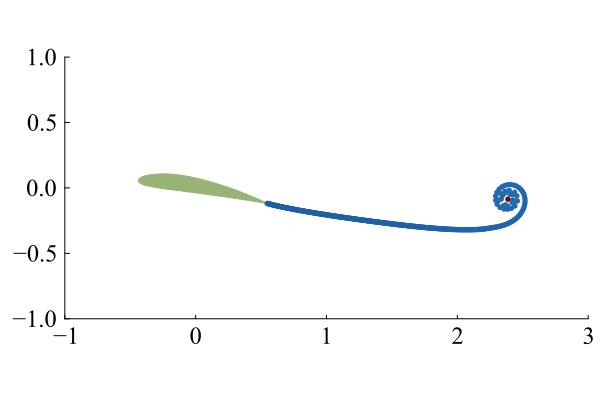

In [13]:
tkfont = Plots.font("Times New Roman",15)
ps = plot(vorticity[end],legend=false,markerstrokewidth=0,color=cgrad(:RdBu,rev=true),markersize=3,tickfont=tkfont,ratio=1,xlim=(-1,3),ylim=(-1,1)) #

#### Tracer particles

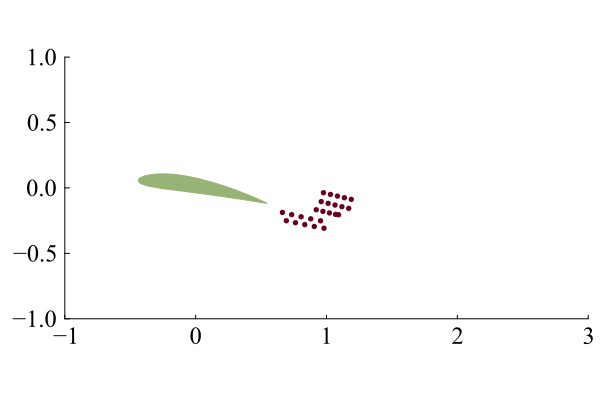

In [14]:
tkfont = Plots.font("Times New Roman",15)
ps = plot(tracers[end],legend=false,markerstrokewidth=0,color=cgrad(:RdBu,rev=true),clim=(-1e-8,1e-8),markersize=3,tickfont=tkfont,ratio=1,xlim=(-1,3),ylim=(-1,1)) #

### Plot the force coefficients

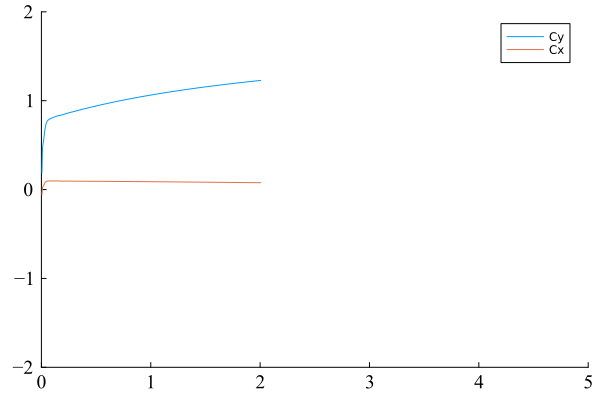

In [15]:
force = -diff(imp)/Δt
tkfont = Plots.font("Times New Roman",12)
plot(time,2*imag.(force),tickfont=tkfont,label="Cy",xlim=(0,5),ylim=(-2,2))
plot!(time,2*real.(force),label="Cx")

In [16]:
using Statistics

In [17]:
println("Mean lift coefficient = ",Statistics.mean(2*imag.(force)))
println("Mean drag coefficient = ",Statistics.mean(2*real.(force)))

Mean lift coefficient = 1.0383119099930727
Mean drag coefficient = 0.08669043665803317


### Plotting streamlines

Set up a Cartesian grid on which to plot

In [42]:
xg = range(-1,1,length=101)
yg = range(-1,1,length=101)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b);

Enforce no-flow-through in the circle plane

In [43]:
Bodies.clear_images!(b)
Bodies.enforce_no_flow_through!(b, motion, (fs_circle,ambient_ω_ζ), t)

Plot the streamlines of the current system of body and vortices

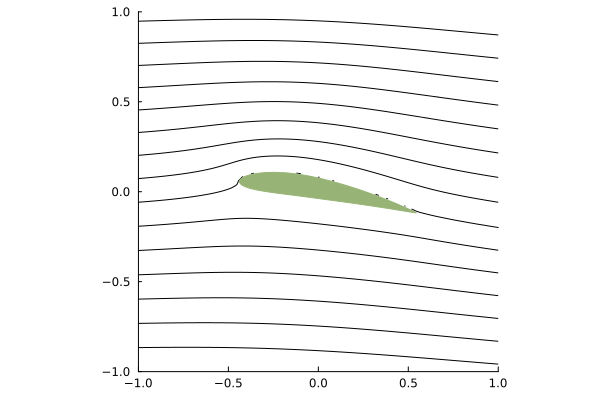

In [44]:
ps = streamlines(xg,yg,ζg,(b,fs_circle,ambient_ω_ζ),xlim=(-1,1),ylim=(-1,1))
plot!(ps,b)